In [ ]:
## これは何?

初心者向け講座#1の内容から学習・予測に不要な部分を排除した notebook です。メインの処理を追い駆けたい!という時にお使いください。

## Note:

**事前学習済みモデルは利用禁止です!**

### 基本の設定

In [1]:
# timer用
!pip install python-vivid

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 307kB 22.6MB/s 
     |████████████████████████████████| 174kB 43.9MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 143kB 39.4MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 112kB 49.3MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=294aceed105923c954f04b8615b643716fc1f38d300c70e9a905de689ef286a2
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [2]:
import os

import pandas as pd
import numpy as np
from glob import  glob

import matplotlib.pyplot as plt
import seaborn as sns

from vivid.utils import timer
from tabulate import tabulate
from collections import defaultdict

In [3]:
!nvidia-smi

Tue Jul 13 11:05:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 各種ディレクトリの定義

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_root = '/content/drive/MyDrive/atmacup11/'
assert dataset_root is not None

input_dir = os.path.join(dataset_root, "datasets")
photo_dir = os.path.join(input_dir, "photos")

output_dir = os.path.join(dataset_root, "outputs_nb007")
os.makedirs(output_dir, exist_ok=True)

train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

material_df = pd.read_csv(os.path.join(input_dir, 'materials.csv'))
technique_df = pd.read_csv(os.path.join(input_dir, 'techniques.csv'))

In [6]:
class Config:
    N_FOLDS = 5
    N_EPOCHS = 30

### 画像データの読み込み

In [7]:
from PIL import Image

def to_img_path(object_id):
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id):
    return Image.open(to_img_path(object_id))

In [8]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils import data

# torchvision
from torchvision import transforms as T
from torchvision.models import resnet34

# scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [9]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "target"

    @property
    def meta_keys(self):
        retval = [self.object_path_key]

        if self.is_train:
            retval += [self.label_key]

        return retval

    def __init__(self, meta_df: pd.DataFrame, is_train=True):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります
            
            is_train:
                True のとき学習用のデータ拡張を適用します.
                False の時は単に size にリサイズを行います
        """

        self.is_train = is_train
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError("meta df must have {}".format(k))

        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")

        size = (224, 224)

        additional_items = (
            [T.Resize(size)]
            if not is_train
            else [
                T.RandomGrayscale(p=0.2),
                T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                T.ColorJitter(
                    brightness=0.3,
                    contrast=0.5,
                    saturation=[0.8, 1.3],
                    hue=[-0.05, 0.05],
                ),
                T.RandomResizedCrop(size),
            ]
        )

        self.transformer = T.Compose(
            [*additional_items, T.ToTensor(), T.Normalize(mean=IMG_MEAN, std=IMG_STD)]
        )

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = Image.open(obj_path)
        img = self.transformer(img)
        return img, label

    def __len__(self):
        return len(self.meta_df)

In [10]:
# CUDA を使うので確認. google colab の場合 GPU accelerator をオンにしておいてください
assert torch.cuda.is_available()

DEVICE = torch.device("cuda")

## Train / Validation Phase

In [11]:
def train(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: data.DataLoader
) -> pd.Series:

    # train にすることで model 内の学習時にのみ有効な機構が有効になります (Dropouts Layers、BatchNorm Layers...)
    model.train()
    
    criterion = nn.MSELoss()

    # ロスの値を保存する用に dict を用意
    metrics = defaultdict(float)
    n_iters = len(train_loader)
    
    for i, (x_i, y_i) in enumerate(train_loader):
        x_i = x_i.to(DEVICE)
        y_i = y_i.to(DEVICE).reshape(-1, 1).float()

        output = model(x_i)
        loss = criterion(output, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metric_i = {
            # loss は tensor object なので item をつかって python object に戻す
            "loss": loss.item()
        }
        for k, v in metric_i.items():
            metrics[k] += v

    for k, v in metrics.items():
        metrics[k] /= n_iters

    # Series型を作るが、その時すべての列名に接頭語 train_をつける
    return pd.Series(metrics).add_prefix("train_")

def predict(model: nn.Module, loader: data.DataLoader) -> np.ndarray:
    # train とは逆で model 内の学習時にのみ有効な機構がオフになります (Dropouts Layers、BatchNorm Layers...)
    model.eval()
    
    predicts = []
    
    for x_i, y_i in loader:
        
        # 明示的に勾配を計算しないように指定することができます. 
        # この関数ではモデルの更新はせずに単に出力だけを使いますので勾配は不要です.
        with torch.no_grad():
            output = model(x_i.to(DEVICE))

        predicts.extend(output.data.cpu().numpy())

    pred = np.array(predicts).reshape(-1)
    return pred


def calculate_metrics(y_true, y_pred) -> dict:
    """正解ラベルと予測ラベルから指標を計算する"""    
    return {
        'rmse': mean_squared_error(y_true, y_pred) ** .5
    }


def valid(
    model: nn.Module, 
    y_valid: np.ndarray, 
    valid_loader: data.DataLoader
) -> pd.Series:
    """検証フェーズ
    与えられたモデル・データローダを使って検証フェーズを実行。スコアの dict と予測した値を返す
    """
    
    pred = predict(model, valid_loader)
    score = calculate_metrics(y_valid, pred)

    valid_score = pd.Series(score)
    return valid_score.add_prefix("valid_"), pred

## Run Fold

1. train / valid の loader 作成
2. 以下を epoch 数だけ繰り返す
    1. 学習用データで学習 
    2. 検証用データで検証スコアの算出

In [12]:
def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    output_dir: str,
    n_epochs=30) -> np.ndarray:
    """
    train / valid に分割されたデータで学習と同時に検証を行なう
    """
    
    # 0: 
    #   : 前準備. dataframe から data loader を作成
    train_dataset = AtmaDataset(meta_df=train_df)
    train_loader = data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=2
    )
    
    #   : 検証用の方は is_train=False にしてデータ拡張オフにする
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)
    valid_loader = data.DataLoader(valid_dataset, batch_size=256, num_workers=2)
    
    # 当Fold(CV#)用のdirを作る
    os.makedirs(output_i, exist_ok=True)

    # optimizer の定義
    optimizer = Adam(model.parameters(), lr=1e-3)

    # --- 保存のための変数定義
    score_df = pd.DataFrame()
    valid_score = np.inf
    valid_score_key = "valid_rmse"
    valid_best_pred = None

    for epoch in range(1, n_epochs + 1):
        print(f'|||. start epoch = {epoch}.  |||')
        
        # print("===start train===")
        # 1: 学習用データで学習を実行。学習時のロスを取得
        with timer(prefix="train: epoch = {}".format(epoch)):
            score_train = train(model, optimizer, train_loader)

        # print(score_train)

        # print("===start valid===")
        # 2: 検証データでのスコアを計算
        with timer(prefix="validate"):
            score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)

        # print(score_valid)

        # --- 学習のロスと検証スコアの値をデータフレームに追加
        # pd.concat : DataFrame , Seriesを連結する
        row = pd.concat([score_train, score_valid])
        row["epoch"] = epoch
        row = pd.DataFrame([row])
        # tabulate : 表形式で表示してくれる
        # 多分どんどん行が増えてくるはず？ Yes!
        print(tabulate(row, headers=row.columns))
        score_df = pd.concat([score_df, row], ignore_index=True)
        # ---

           
        #  今の検証スコアと過去最高のスコアを比較
        current_score = score_valid[valid_score_key]
        if current_score < valid_score:
            # スコア改善したときモデルを保存する
            print(f'validation score is improved!! {valid_score:.4f} -> {current_score:.4f}')
            torch.save(
                model.state_dict(), os.path.join(output_dir, 'model_best.pth')
            )
            valid_score = current_score
            valid_best_pred = y_valid_pred

    score_df.to_csv(os.path.join(output_dir, 'score.csv'), index=False)
    return score_df


### その他

モデル作成などの関数定義

In [13]:
def create_model():
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)    
    return model
    
def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)
    
    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

def run_test_predict(model):
    test_meta_df = create_metadata(test_df)

    # 学習時のデータ拡張はオフにしたいので is_train=False としている
    test_dataset = AtmaDataset(meta_df=test_meta_df, is_train=False)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=2)
    
    y_pred = predict(model, loader=test_loader)
    return y_pred

# 学習の進捗状況可視化のために関数を定義

In [14]:
# train_loss, valid_rmseの可視化
def draw_result(df, i):
    # set values
    x = df['epoch'].values
    y0 = df['train_loss'].values
    y1 = df['valid_rmse'].values

    # set background color to white
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    # plot lines
    plt.xlabel('epoch')
    plt.plot(x, y0, label='train_loss')
    plt.plot(x, y1, label='valid_rmse')
    plt.legend()

    # plt.show()
    fig.savefig(os.path.join(output_dir, f"cv{i}_result.png"))

# ここから学習実施

In [16]:
def get_output_dir(n_cv: int):
    return os.path.join(output_dir, 'simple_resnet', f'cv={n_cv}')

In [ ]:
train_meta_df = create_metadata(train_df)

******************************
****  cv = 0   ***
******************************
|||. start epoch = 1.  |||
train: epoch = 1 23.013[s]
validate 2.958[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       1.81013       1.01621        1
validation score is improved!! inf -> 1.0162
|||. start epoch = 2.  |||
train: epoch = 2 23.130[s]
validate 2.922[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.975861       1.00246        2
validation score is improved!! 1.0162 -> 1.0025
|||. start epoch = 3.  |||
train: epoch = 3 23.212[s]
validate 2.930[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.948775      0.947678        3
validation score is improved!! 1.0025 -> 0.9477
|||. start epoch = 4.  |||
train: epoch = 4 23.329[s]
validate 2.901[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.937057      0.992613        4
|||. start

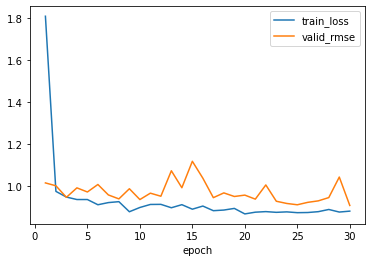

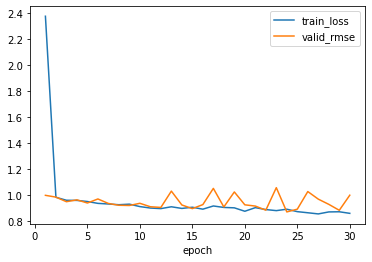

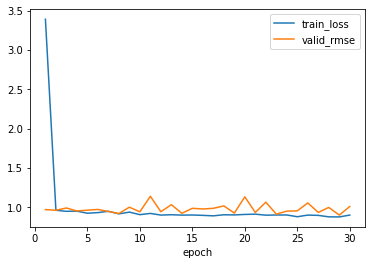

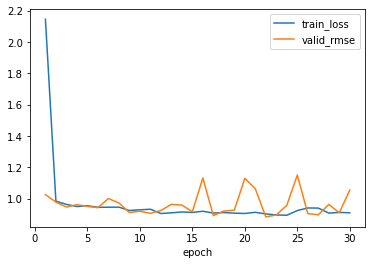

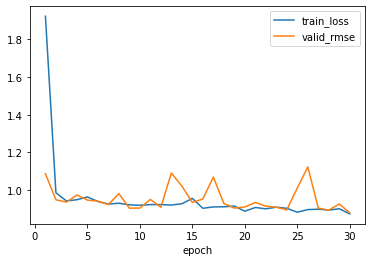

In [ ]:


fold = KFold(n_splits=5, shuffle=True, random_state=510)
cv = list(fold.split(X=train_df, y=train_df['target']))[:Config.N_FOLDS]

for i, (idx_tr, idx_valid) in enumerate(cv):
    output_i = get_output_dir(i)
    model = create_model()
    model.to(DEVICE)
    
    # 今、cv何番目かを出力
    print("******************************")
    print(f"****  cv = {i}   ***")
    print("******************************")

    # 1. Fold の学習
    df =  run_fold(
            model=model, 
            train_df=train_meta_df.iloc[idx_tr], 
            valid_df=train_meta_df.iloc[idx_valid], 
            y_valid=train_meta_df['target'].values[idx_valid],
            n_epochs=Config.N_EPOCHS, 
            output_dir = output_i
        )
    
    # cv=iでの学習の結果を可視化・保存する
    draw_result(df, i)
 
    # 2. モデルで予測 (本当はローカルに保存した重みを読みだすなどするほうがあとで振り返りやすいが簡易にそのまま予測する)
    # y_pred_i = run_test_predict(model)
    # test_predictions.append(y_pred_i)

- 今、CV何番目かが分からない
- trainとvalのRMSElossの進捗の様子を可視化したい

テストデータに対して予測

In [20]:
fold = KFold(n_splits=5, shuffle=True, random_state=510)
cv = list(fold.split(X=train_df, y=train_df['target']))[:Config.N_FOLDS]

In [23]:
test_predictions = []

for i in range(len(cv)):
    output_i = get_output_dir(i)
    
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    
    model_path = os.path.join(output_i, 'model_best.pth')
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    
    y_pred_i = run_test_predict(model)
    test_predictions.append(y_pred_i)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [17]:
get_output_dir(1)

'/content/drive/MyDrive/atmacup11/outputs_nb007/simple_resnet/cv=1'

In [24]:
# すべての予測の平均値を使う
pred_mean = np.array(test_predictions).mean(axis=0)

pd.DataFrame({
    "target": pred_mean
}).to_csv(os.path.join(output_dir, "007__submission.csv"), index=False)